# Visualization methods for Convolutional Neural Networks

CNNs have been extremely successful, but since they perform _feature construction_, they are even more black-box than other models. For many practical applications, it is important to try and make sense of what the network learned. Here below are a few methods that can be used and easily implemented in pytorch. 

## _Almost_ a real model: VGG-16
Since so far we worked with toy models, let's try something more complex. VGG-16 is a CNN that was considered the state of the art for image recognition...in 2014. See the paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556).

The architecture of VGG-16 is depicted in the image below. Luckily, pytorch (and in particular the torchvision library) gives us access to the whole network with pre-trained parameters. It might take a while to download (it's around 500MB), but it's easy.

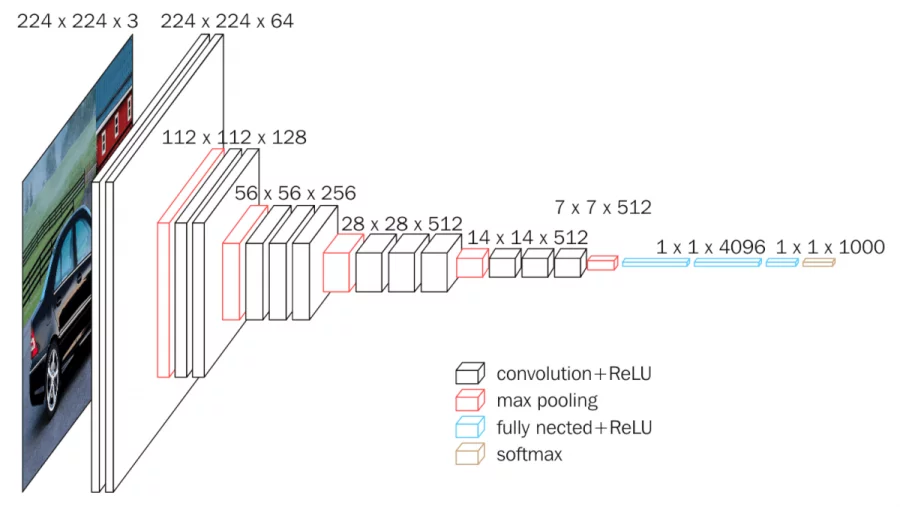

In [ ]:
# classic imports
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import requests

import torch
import torchvision
from torch.optim import Adam
from torchvision import models

from PIL import Image, ImageFilter
from torch.autograd import Variable

In [ ]:
# let's get our model!
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(vgg16)
total_parameters = sum(p.numel() for p in vgg16.parameters())
print("This chonker of a model has %s parameters!" % "{:,}".format(total_parameters))

Several times during the class, we repeated that using pre-trained models with pytorch is easy. Let's put this statement to the test! VGG-16 was originally trained for a classification competition, featuring image samples from 1,000 classes, so one dimension of the output tensor will be 1,000, with one value for each class, the highest being the class that the network predicted for the sample. The images have to be exactly 224x224 pixels, as that was the format for the competition. Let's find something from the internet and try to classify it. It would also be nice to have the _description_ of the class labels, to verify if the results make sense. Let's get all the necessary components and give VGG-16 a trial run.

In [ ]:
# get an image from the internet using the PIL library; I intentionally picked an image that IS NOT
# part of the images used to train VGG-16, it's a high-resolution cat on the internet
# you can actually change the URL and use another image, but it will probably require modifying the
# transformations below
image_url = "https://api.time.com/wp-content/uploads/2014/07/492290913.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

# torchvision has a utility function to transform the image in a tensor
image_tensor = torchvision.transforms.functional.pil_to_tensor(image)
print("Image tensor has shape:", image_tensor.shape)

fig, ax = plt.subplots()
# .permute() here below offers a view of the tensor with the dimensions switched; this is because
# in neural networks (and pytorch), traditionally the dimension defining the channels (R,G,B) comes
# first, while in matplotlib.pyplot.imshow() it has to come in last; so the call .permute(1,2,0)
# just means "return a view that puts dimension 1 first, dimension 2 second, and dimension 0 last"
ax.imshow(image_tensor.permute(1,2,0).numpy()) 
ax.set_title("Look at this adorable but GIANT cat, measuring %s x %s pixels" % 
             ("{:,}".format(image_tensor.shape[1]), "{:,}".format(image_tensor.shape[2])))

In [ ]:
# luckily, we can run some transformations to crop the image to a square, and then resize it, using
# other torchvision transformations
image_width = image_tensor.shape[2]
image_height = image_tensor.shape[1]
image_tensor = torchvision.transforms.functional.crop(image_tensor, top=0, 
                                        left=image_width-image_height, 
                                        height=image_height,
                                        width=image_height,
                                            )
print("Image tensor after cropping has now shape:", image_tensor.shape)

image_tensor = torchvision.transforms.functional.resize(image_tensor, (224, 224))
print("Image tensor after resizing has now shape:", image_tensor.shape)

fig, ax = plt.subplots()
ax.imshow(image_tensor.permute(1,2,0).numpy()) 
ax.set_title("Look at this adorable cat, now measuring a more reasonable %s x %s pixels" % 
             ("{:,}".format(image_tensor.shape[1]), "{:,}".format(image_tensor.shape[2])))

And now, after pre-processing the image, we can finally send it through VGG-16 and look at the result!

In [ ]:
# we still need a few more transformation, casting the data type of the tensor to float32,
# and normalizing everything using means and standard deviations,
# taken from the ImageNet literature; when performing multiple chained transformations, we can apply
# the Compose functionality. Here we use the most recent version of the transformations, namespace "v2"
# print(torchvision.__version__) # this was just a debug print, we need at least torchvision 0.17
from torchvision.transforms import v2
composed_transformation = torchvision.transforms.Compose(
                        [
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=(0.485, 0.456, 0.406), 
                                        std=(0.229, 0.224, 0.225))
                        ]
                        )
image_tensor = composed_transformation(image_tensor)

In [ ]:
# we can finally send the image through VGG-16!
# first, we need to unsqueeze the image tensor, currently of shape [n_channels, height, width] 
# to add another dimension, as the tensor that VGG-16 expects in input has shape
# [n_samples, n_channels, height, width], so we add another dimension in the first position (dim=0)
print("Performing forward pass with the image...")
vgg16.eval()
y_hat = vgg16(image_tensor.unsqueeze(dim=0))
print("Done! Shape of the output tensor:", y_hat.shape)

# the output is clearly a tensor of shape [1,1000], where 1,000 are the classes used for the ImageNet
# competition; the class prediction will be the highest value in the resulting tensor
class_prediction = torch.argmax(y_hat, dim=1).item()

# unfortunately, we don't have the class labels readily somewhere in pytorch; but we can download them from
# the best available source, a random GitHub repository
imagenet_index_to_label_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
r = requests.get(imagenet_index_to_label_url)
# using a library called 'ast' to quickly parse the text file into a dictionary
import ast
imagenet_index_to_label = ast.literal_eval(r.text)

print("The class label for the predicted class is (drum roll): index #%d, \"%s\"" % 
      (class_prediction, imagenet_index_to_label[class_prediction]))

# we can even sort the predictions in the y_hat tensor from highest to lowest, to have an idea of
# what could be other likely classes; we convert the tensor to a numpy array, and use a numpy function
# to obtain an array of indexes
indexes_by_likelihood = np.argsort(-y_hat.detach().squeeze().numpy())
top_classes = [imagenet_index_to_label[indexes_by_likelihood[i]] for i in range(0, 5)]
print("Top 5 most likely classes:", top_classes)

# this worked so well that I am keeping a copy of the input image tensor, so that I can use it later
image_tensor_cat = image_tensor.clone()
class_index_for_image_tensor_cat = class_prediction

Easy, right? It took me only **four whole hours** to make this part of the code work, but to be fair it was mostly because of stupid issues with image preprocessing and having an older version of torchvision. Obtaining and using the pre-trained models is easy.

Now, try to download, preprocess, and send through the network another image of your choice, checking if the classification label is correct. You can take a look at the imagenet_index_to_label dictionary to have an idea of the type of objects that the VGG-16 network has been trained to recognize. You can use the preprocessing pipeline below to easily apply a "center crop" (cropping so that it looks like a square, centered on the middle point of the image).

In [ ]:
# download image and visualize it; TODO: change the url (note: some websites forbid direct access to images,
# if you get errors with the request, just pick another image, or download it and find a way to access
# and load the file from your notebook)
image_url = "https://api.time.com/wp-content/uploads/2014/07/492290913.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image_width, image_height = image.size
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Image: %d x %d pixels" % (image_width, image_height))

# apply preprocessing to: convert image to a tensor, center crop it, resize it, and normalize it
# using torchvision.transforms.Compose is pretty convenient here, as we can define our pre-processing
# pipeline once, and then re-use it with just one call
imagenet_composed_transformation = torchvision.transforms.Compose(
                        [
                            v2.PILToTensor(),
                            # here, it is cropping using the smallest dimension
                            v2.CenterCrop(min(image_height, image_width)), 
                            v2.Resize((224, 224)),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=(0.485, 0.456, 0.406), 
                                        std=(0.229, 0.224, 0.225))
                        ]
                        )
image_tensor = imagenet_composed_transformation(image)
fig, ax = plt.subplots()
ax.imshow(image_tensor.permute(1, 2, 0).numpy())
ax.set_title("Image after cropping, resizing, normalizing: %d x %d pixels" % 
             (image_tensor.shape[1], image_tensor.shape[2]))

# TODO: now pass the image_tensor through the network, collect the output tensor,
# and use the dictionary imagenet_index_to_label to obtain the class label

## Visualizing features constructed/extracted by the CNN

Now that everything is running, we can start by checking the features extracted by VGG-16. In order to do so, we will have to check the intermediate outputs of each module. There are lots of modules and lots of outputs, but luckily we have complete access to the network: we know its architecture, and we even have access to each of its individual layers. A first, straightforward way to visualize what is happening is to run the input image tensor through the layers, one by one, and interpret the outputs as images. Let's see an example for the first layer.

In [ ]:
# let's first print out the names of the modules
for name, module in vgg16.named_modules() :
    print(name)

Now, you might have noticed that VGG-16 has several modules named `features.NUMBER` and `classifier.NUMBER`. VGG-16 is using a specific type of nested architecture, where the modules have been grouped into three parts, called: `features`, `avgpool`, and `classifier`. Just calling `vgg16.features` will return a reference to the whole set of modules that are part of that group. We can access a single module in a group (called `torch.nn.Sequential`) by treating it as a list and specifying for example `vgg16.features[4]`.

In [ ]:
print("This is the whole set of torch.nn.Sequential modules called \"features\":", vgg16.features)
print("This is the first module:", vgg16.features[0])

Now that we know how to access single modules group together in a `torch.nn.Sequential` object, let's visualize the output of the first module.

In [ ]:
vgg16_module = vgg16.features[0] # reference to the module we are interested in
print("The target module has %d parameters" % 
      sum(p.numel() for p in vgg16_module.parameters() if p.requires_grad))

# let's pass the image through the network
output_tensor_module = vgg16_module(image_tensor)
print("The original input had shape: %s; the output of the module has shape: %s"
     % (str(image_tensor.shape), str(output_tensor_module.shape)))

# the first module is a Conv2D with 64 "filters", let's visualize the output
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
for row in range(0, 8) :
    for column in range(0, 8) :
        filter_index = row + column * 8
        # ax[row, column].imshow(...) # TODO you need to write this part
        ax[row, column].set_title("Output of filter %d" % (filter_index))
        

Now, modify the cell above to do the same for another convolutional module, this time close to the end of the neural network. How do the features look like?

It might also be interesting to check how features change as the image tensor goes through more and more modules. Let's plot just one dimension of the intermediate output tensor per module, and see what happens.

In [ ]:
# fix a particular value of the output dimension that we are going to check
output_dimension = 0

# let's create a copy of the original image tensor, so that we can work on it without messing up
z_tensor = image_tensor.clone()

# there are a total of 31 modules, so we can create a plot with 32 subplots and put the image in ax[0, 0]
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(16, 32))

for row in range(0, 8) :
    for column in range(0, 4) :
        if row == 0 and column == 0 :
            ax[row, column].imshow(image_tensor.permute(1, 2, 0).numpy())
            ax[row, column].set_title("Original image")
        else :
            module_index = row * 4 + column - 1
            z_tensor = vgg16.features[module_index](z_tensor)
            # let's work again on a copy, to avoid issues
            module_output_tensor = z_tensor.clone()
            # TODO you have to do this part; pick a slice of the output tensor
            # and visualize it as an image with .imshow()
            # <STUDENTS>
            ax[row, column].imshow(module_output_tensor[output_dimension, :, :].detach().numpy())
            ax[row, column].set_title("Output of module %d" % module_index)
            # </STUDENTS>

While this visualization is very cool (albeit a bit psychedelic), ultimately it is not very informative. There are better visualization methods for CNNs, and we are going to see them in the next exercises.

## Saliency maps

The idea at the base of saliency maps is to identify the areas of the image that most impact the final decision for the class. The intuition is to send the image tensor through the network, and evaluate the gradient of the value of the element of the output tensor corresponding to the correct class, with _respect to each pixel_ of the original image.

High absolute values of the gradient for a pixel indicate that that pixel might be fundamental for the decision: in other words, slightly changing the value of a pixel for which there is a high gradient could strongly impact the value of the tensor at the output of the network, and thus change the classification.

Step by step, the method consists in:
1. Sending the image tensor through the whole network (forward pass), with `requires_grad=True`.
2. Compute the backward from the output score of the target class.
3. Visualize the absolute value of the gradient with respect to the each element (pixel) in the image tensor. If an image tensor has multiple channels (RGB), we pick the maximum value of the gradient for each channel corresponding to the same pixel.

In [ ]:
def get_saliency(model, img, label):
    # reset gradients in the model
    model.zero_grad()
    # activate gradient computation for image tensor, initialize gradients to None 
    img.requires_grad = True
    img.grad = None
    # compute output of the model
    model_output = model(img.unsqueeze(0))
    # compute a softmax on the output, to get something more similar to class probabilities
    softmax_output = torch.nn.Softmax(dim=1)(model_output)
    # only consider the output value for the true class label
    softmax_output = softmax_output[0, label]
    # backward pass
    softmax_output.backward()
    # get the absolute values of the gradients for each element of the input tensor
    sal = img.grad.abs()
    # if the input tensor had more than two dimensions (e.g. because of 3 channels)
    # resize the saliency map to two dimensions by taking the highest gradient value
    # for each channel
    if sal.dim() > 2:
        sal = torch.max(sal,dim=0)[0]
    return sal

# this example below is using my beloved cat image; TODO: replace it with the image you selected
saliency = get_saliency(vgg16, image_tensor_cat, class_index_for_image_tensor_cat)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax[0].imshow(image_tensor_cat.detach().cpu().squeeze(0).permute(1, 2, 0))
ax[0].set_title("Original image")
ax[1].imshow(saliency.to('cpu'), cmap="seismic") #, interpolation="bilinear")
ax[1].set_title("Saliency map for image with respect to class index %d (%s)" %
               (class_index_for_image_tensor_cat, imagenet_index_to_label[class_index_for_image_tensor_cat]))

## Gradient-weighted Class Activation Maps (Grad-CAM)

Saliency maps, however, use only the information from the final output to the original pixels. As the last modules performing convolutions map to large areas of the original image, it would be interesting to know the importance of the output of the last modules on the final classification performance. Unfortunately, the last part of most CNNs is a set of linear modules + activations, creating a high complexity of non-linearities that makes it harder to assess the impact of each output on the final class label. This is also true for VGG-16, where the last modules of the network are grouped together in a `torch.nn.Sequential` object called `classifier`. Look at how many parameters it has!

In [ ]:
print(vgg16.classifier)
print("Total number of parameters:", "{:,}".format(sum(p.numel() for p in vgg16.classifier.parameters())))

The idea of Grad-CAM is to replace the last part of a CNN with a simple linear module, accepting a higher classification error in exchange for an easier assessment of the impact of each output of the convolutional modules on the final result. This would normally require replacing the last modules of the network with a linear module, and retraining it on the training set. We ain't got time to do that, so we are going to exploit a visualization library built on top of pytorchvision, called [pytorchgradcam](https://github.com/jacobgil/pytorch-grad-cam/tree/master), where this has been done for us by Jacob Gildenblat.

In [ ]:
!pip install grad-cam --quiet

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# for several reasons, we have to reload the image here, as pytorch_grad_cam likes to work with a specific
# format for visualizing the original; replace this with your image URL and class index
# TODO: replace the URL and the class index with the image of your choice, and check the results
image_url = "https://api.time.com/wp-content/uploads/2014/07/492290913.jpg"
image_raw = Image.open(requests.get(image_url, stream=True).raw)
image_width, image_height = image_raw.size
cropped_image = image_raw.crop((image_width-image_height, 0, image_width, image_height))
resized_image = cropped_image.resize((224, 224))
# now, we have to separately prepare a resized 'visualizable' image as a numpy array
# because pytorch_grad_cam does only likes images with a certain format
visualizible_image = np.array(resized_image)
visualizible_image = np.float32(visualizible_image) / 255

# here comes the interesting part; we define a GradCAM object, and all related necessary information
# first, the layers we are interested in; it can be a list, here it's just the last layer in 'features'
target_layers = [ vgg16.features[-1] ]
# instantiate the GradCAM object
cam = GradCAM(model=vgg16, target_layers=target_layers)
# we also need the classification target, a ClassifierOutputTarget object that needs the class index
targets = [ ClassifierOutputTarget(class_index_for_image_tensor_cat) ]

# let's run the gradcam! the output is a tensor of greyscale maps that show the most important parts
# of the image
greyscale_map = cam(input_tensor=image_tensor_cat.unsqueeze(0), targets=targets)
# in this example, there was just one image, so let's take the first grayscale map
greyscale_map = greyscale_map[0, :]

# and now, we can plot everything using a utility function that overlaps the greyscale map to the image
cam_image = show_cam_on_image(visualizible_image, greyscale_map, use_rgb=True)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax[0].imshow(visualizible_image)
ax[0].set_title("Original image")
ax[1].imshow(greyscale_map, cmap="Greys")
ax[1].set_title("Greyscale CAM")
ax[2].imshow(cam_image)
ax[2].set_title("CAM overlapped on the original image")

The pytorchgradcam library also contains more advanced versions of GradCAM-based visualization methods for CNNs, and metrics that can be used to compare different methods. If you are interested, [the tutorials, including ipython notebooks, can be found here](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html).

## Visualization of feature patterns

If you remember the short introduction to xAI that we saw during the class, you might also recall that there are two different types of explanations: local (why did the ML algorithm answer in this way for this particular sample?) and global (from the point of view of the ML algorithm, what are the characteristics of a certain class in a classification problem?). The examples we saw so far are all _local_ explanations, trying to make sense of one sample. We are now going to see an attempt at a more _global_ explanation of CNN behavior, finding out the patterns recognized by the each filter in the Convolutional modules.

The approach is to _generate an image_ such that it maximizes one output in a particular module. We can frame this task as an optimization problem, and employ gradients: in particular, we can compute the gradients on the pixels with respect to the target output, and optimize the pixel values with a gradient descent algorithm. In this case, instead of minimizing, we are attempting to _maximize_ the target output value.

Let's try to do that, with some code stolen directly from the GitHub repository of [Utku Ozbulak](github.com/utkuozbulak), that also features examples of several other visualization techniques for CNNs. 

In [ ]:
import copy
import os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models

from PIL import Image, ImageFilter
from torch.autograd import Variable

def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self, iterations=100):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, iterations+1):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            if i % 10 == 0 or i == iterations-1 :
                print('Iteration:', str(i), 'Loss:', "{0:.2e}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 10 == 0 or i == 1 :
                im_path = './generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)


if not os.path.exists("generated") :
  os.makedirs("generated")

# after defining all these functions, we can set the target layer; for several reasons,
# it's easier to just work on the part of VGG-16 that creates the features
pretrained_model = vgg16.features
module_index = 1 # it's better to check what happens after ReLUs, so index 1 is the first and 29 is the last
filter_position = 2 # we also need to select the filter in the module
layer_vis = CNNLayerVisualization(pretrained_model, module_index, filter_position)

# the results are saved as images in the directory "./generated", with file names
# in the format "layer_vis_l<MODULE>_f<FILTER>_iter<ITERATION>.jpg"
layer_vis.visualise_layer_with_hooks(iterations=100)

# we can now visualize a few selected images
iterations_to_visualize = [1, 20, 50, 100]
fig, ax = plt.subplots(nrows=1, ncols=len(iterations_to_visualize), 
                       figsize=(4 * len(iterations_to_visualize), 4))
for index, iteration in enumerate(iterations_to_visualize) :
    image_file_name = "./generated/layer_vis_l%d_f%d_iter%d.jpg" % (module_index, filter_position, iteration)
    ax[index].imshow(Image.open(image_file_name))
    ax[index].set_title("Module %d, filter %d, iteration %d" % 
                        (module_index, filter_position, iteration))


Now, the general consensus is that the "features" visualized by these images increase in "complexity" as the we go deeper into the network. For the first modules, you should see simple repeated patterns all over the place. Higher modules should have more complex patterns, spanning the whole image.

Let's try to perform a longitudinal test. We will keep the target filter index fixed, and we will attempt to visualize all outputs in deeper and deeper modules.

In [ ]:
indexes_of_all_relu_modules = [i for i in range(0, len(pretrained_model)) 
                               if isinstance(pretrained_model[i], torch.nn.ReLU)]
print("Indexes of all ReLU modules in vgg.features:", indexes_of_all_relu_modules)

In [ ]:
filter_position = 4
max_iterations = 100
for module_index in indexes_of_all_relu_modules :
    print("Now optimizing image for module %d..." % module_index)
    layer_vis = CNNLayerVisualization(pretrained_model, module_index, filter_position)
    layer_vis.visualise_layer_with_hooks(iterations=max_iterations)

In [ ]:
# and now, some plotting    
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for row in range(0, 4) :
    for column in range(0, 4) :
        index = row * 4 + column
        if index < len(indexes_of_all_relu_modules) :
            module_index = indexes_of_all_relu_modules[index]
            image_file_name = "./generated/layer_vis_l%d_f%d_iter%d.jpg" % (module_index, filter_position, max_iterations)
            ax[row, column].imshow(Image.open(image_file_name))
            ax[row, column].set_title("Module %d, filter %d" % (module_index, filter_position))